In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from tqdm import tqdm
# Regression
import statsmodels.api as sm
# LASSO
from sklearn import model_selection
from sklearn.linear_model import Lasso
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# XGBoost
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

import warnings
warnings.simplefilter(action='ignore')

In [2]:
def draw_predict_perform(df):
    df_sorted = df.sort_values('predict',ascending=True)
    df_sorted['decile'] = pd.qcut(df_sorted['predict'],10,labels=False)
    grouped = df_sorted[['y','predict','decile']].groupby('decile').mean()
    print(grouped)
    plt.bar(grouped.index,grouped['y'])
    plt.grid(True,alpha=0.4)
def draw_distribution(df):
    plt.ylabel('Real Return')
    plt.xlabel('Predict Return')
    plt.scatter(x = df['predict'],y =df['y'])
    plt.axhline(0,linestyle='--',color='black')
    plt.axvline(0,linestyle='--',color='black')
    df = df.dropna()
    model = sm.OLS(df['y'],sm.add_constant(df['predict'])).fit()
    # print(model.params)
    try:
        plt.plot(df['predict'],df['predict']*model.params['predict']+model.params['const'],color='r')
    except:
        plt.plot(df['predict'],df['predict']*model.params['predict'],color='r')
def confusion_matrix(df):
    df['predict_signal'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,np.nan))
    df['real_signal'] = np.where(df['y']>0,1,np.where(df['y']<0,-1,np.nan))
    df['accuracy'] = np.where((df['predict_signal']==1)&(df['real_signal']==1),'TP',np.where((df['predict_signal']==1)&(df['real_signal']==-1),'FP',np.where((df['predict_signal']==-1)&(df['real_signal']==1),'FN','TN')))
    accuracy_matrix = pd.DataFrame(columns = ['Real Yes','Real No'],index = ['Predict Yes','Predict No'])
    tp = df[df['accuracy']=='TP']
    fp = df[df['accuracy']=='FP']
    fn = df[df['accuracy']=='FN']
    tn = df[df['accuracy']=='TN']
    accuracy_matrix.loc['Predict Yes','Real Yes'] = len(tp)/len(df)
    accuracy_matrix.loc['Predict Yes','Real No'] = len(fp)/len(df)
    accuracy_matrix.loc['Predict No','Real Yes'] = len(fn)/len(df)
    accuracy_matrix.loc['Predict No','Real No'] = len(tn)/len(df)


    print(f'Prevaience: {(len(tp)+len(fn))/len(df)}')
    print(f'Accurancy:{(len(tp)+len(tn))/len(df)}')
    print(f'Precision:{len(tp)/(len(tp)+len(fp))}')
    print(f'Recall:{len(tp)/(len(tp)+len(fn))}')
    print(f'F1 Score: {2/(1/(len(tp)/(len(tp)+len(fp)))+1/(len(tp)/(len(tp)+len(fn))))}')
    print(f'Accurancy of No : {len(tn)/(len(fp)+len(tn))}')

    return accuracy_matrix

In [3]:
data = pd.read_csv('NQ.csv')
factors = pd.read_csv('factor.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,y,a1,a2,b1,b2,b3,b4,b5,b6,b7,...,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,0.000555,0.675009,0.67,2.029210,1.61,1.354201,0.94,2.40,18.70,80.56,...,-1.25,-2.029728,-1.92,1.65,72.17,38.37,-1.579,13.25,-3.08,-0.02
2020-01-10,-0.006665,0.012606,0.81,0.779468,2.12,0.766862,1.31,1.37,26.23,84.60,...,-0.80,-1.952923,-1.61,3.25,28.33,35.54,-1.813,13.51,-3.73,-0.95
2020-01-13,0.007542,-0.585729,-0.27,-0.086929,0.23,0.498800,0.50,1.42,-15.69,84.98,...,-2.30,-1.453885,-2.03,2.26,-1.09,28.82,-2.286,14.27,-5.64,-3.27
2020-01-14,-0.002971,0.653482,1.04,1.707098,2.14,1.053616,1.10,1.87,-14.73,88.06,...,0.66,-0.266841,-0.38,1.37,-51.36,32.75,-2.420,14.98,-4.62,-2.71
2020-01-15,0.001105,-0.207969,-0.24,-1.269340,-1.35,-1.061371,-1.11,1.73,35.38,76.77,...,2.32,2.254327,2.56,2.45,46.02,44.84,-2.038,14.63,-2.29,-0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,-0.000209,-0.984979,-0.93,-0.657744,-0.48,0.327235,0.45,2.86,-14.12,40.59,...,-1.37,-0.337247,-0.44,5.38,-11.75,34.64,-2.828,24.21,-9.41,-1.07
2024-07-29,-0.005282,0.149617,1.03,-0.338363,0.22,-0.487980,-0.81,1.60,-18.87,41.68,...,1.59,-1.367858,0.56,2.41,-31.09,38.36,-2.810,24.55,-7.78,0.26
2024-07-30,-0.016868,-0.425302,0.07,0.589971,0.13,1.015273,0.06,1.63,-13.03,42.38,...,-0.93,-0.758752,-1.00,3.89,-20.37,36.97,-2.702,24.56,-8.35,-0.96


In [4]:
# 用前一期填上空值
df_fill = data.dropna()
# df_fill = data.fillna(method='ffill')

df_features = df_fill.iloc[:,1:]
df_features = df_features.pct_change().dropna()
df_features.replace([np.inf,-np.inf],np.nan,inplace=True)
df_features = df_features.fillna(method='ffill')

df_clean = df_features.copy()
df_clean['y'] = df_fill['y']

df_dir = df_clean.copy()
for i in df_dir.columns:
    df_dir[i] = np.where(df_dir[i]<0,-1,1)

In [5]:
lead_factor = factors['lead_factor'].dropna().to_list()
lead_factor_days = factors['lead_factors_days'].dropna().to_list()
lead_factor_dir = factors['lead_factor_dir'].dropna().to_list()
lead_factor_dir_days = factors['lead_factor_dir_days'].dropna().to_list()
k_means_pick = factors['k_means'].dropna().to_list()
k_means_dir = factors['k_means_dir'].dropna().to_list()
k_means_y = factors['k_means_y'].dropna().to_list()
k_means_y.remove('y')
k_means_y_dir = factors['k_means_y_dir'].dropna().to_list()
k_means_y_dir.remove('y')
low_corr = factors['low_corr'].dropna().to_list()
low_corr_dir = factors['low_corr_dir'].dropna().to_list()
similar_dir = factors['similar_dir'].dropna().to_list()


### **-------Select Factor -------------------------**

In [6]:
select = lead_factor_dir
print(select)
print(len(select))

['g8', 'h10', 'i11', 'h7', 'c8', 'b3', 'i10', 'c10', 'i2', 'n4']
10


## **Regression**

In [130]:
## value
df = df_clean[select]
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df_clean['y']
df_reg = df.dropna()
time_units = 60

for i in range(len(df_reg)-time_units):
    today = df_reg.iloc[i+time_units].name
    next_day = df_reg.loc[today:].head(2).index[-1]
    ## 固定取值    
    duration = df.iloc[i:i+time_units]
    ## 累加取值
    # duration = df_reg.loc[:today]
    # duration = (duration - duration.mean())/duration.std()

    Y = duration['y']
    X = duration[select]
    model = sm.OLS(Y,sm.add_constant(X)).fit()
    df_reg.loc[next_day,'R-Square'] = model.rsquared*100
    predict=0
    try:
        df_reg.loc[next_day,'const'] = model.params.const
        predict+=df.loc[next_day,'const']
    except:
        df_reg.loc[next_day,'const'] = np.nan
    
    for j in select:
        df_reg.loc[next_day,j+' coef'] = model.params[j]
        predict += (df_reg.loc[next_day,j])*(df_reg.loc[next_day,j+' coef'])
        # predict += (duration[j].mean())*df.loc[next_day,j+'coef']
    df_reg.loc[next_day,'predict'] = predict 
df_reg

MissingDataError: exog contains inf or nans

In [ ]:
# draw_distribution(df_reg)
confusion_matrix(df_reg)

Prevaience: 0.5242451967063129
Accurancy:0.526075022872827
Precision:0.5560081466395111
Recall:0.47643979057591623
F1 Score: 0.513157894736842
Accurancy of No : 0.5807692307692308


,Real Yes,Real No
Predict Yes,0.249771,0.199451
Predict No,0.274474,0.276304


In [131]:
## direction
df_reg_dir = df_dir[select]
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df_reg_dir[item] = df_reg_dir[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df_reg_dir[item] = df_reg_dir[item].shift(int(days))
df_reg_dir['y'] = df_dir['y']
df_reg_dir = df_reg_dir.dropna()
time_units = 60

for i in range(len(df_reg_dir)-time_units):
    today = df_reg_dir.iloc[i+time_units].name
    next_day = df_reg_dir.loc[today:].head(2).index[-1]
    ## 固定取值    
    # duration = df_reg_dir.iloc[i:i+time_units]
    ## 累加取值
    duration = df_reg_dir.loc[:today]
    duration.replace([np.inf, -np.inf], 0, inplace=True)
    # duration = (duration - duration.mean())/duration.std()

    Y = duration['y']
    X = duration[select]
    model = sm.OLS(Y,sm.add_constant(X)).fit()
    df_reg_dir.loc[next_day,'R-Square'] = model.rsquared*100
    predict=0
    try:
        df_reg_dir.loc[next_day,'const'] = model.params.const
        predict+=df_reg_dir.loc[next_day,'const']
    except:
        df_reg_dir.loc[next_day,'const'] = np.nan
    
    for j in select:
        df_reg_dir.loc[next_day,j+' coef'] = model.params[j]
        predict += (df_reg_dir.loc[next_day,j])*df_reg_dir.loc[next_day,j+' coef']
        # predict += (duration[j].mean())*df_reg_dir.loc[next_day,j+'coef']
    df_reg_dir.loc[next_day,'predict'] = predict 
df_reg_dir

,g8,h10,i11,h7,c8,b3,i10,c10,i2,n4,...,h10 coef,i11 coef,h7 coef,c8 coef,b3 coef,i10 coef,c10 coef,i2 coef,n4 coef,predict
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-08,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-09,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-10,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-14,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,0.051731,-0.052996,-0.010744,0.007067,-0.007855,0.003762,0.013488,-0.083023,0.000362,0.096840
2024-07-26,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,0.052590,-0.051847,-0.011857,0.005725,-0.010289,0.004888,0.014628,-0.082536,0.001000,0.135023
2024-07-29,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,...,0.050992,-0.053424,-0.013207,0.004530,-0.009581,0.005968,0.013069,-0.081502,0.002070,0.068842


const      0.089304
predict    0.016965
dtype: float64
Prevaience: 0.5074626865671642
Accurancy:0.5763490241102182
Precision:0.5584
Recall:0.7895927601809954
F1 Score: 0.654170571696345
Accurancy of No : 0.35664335664335667


,Real Yes,Real No
Predict Yes,0.400689,0.316877
Predict No,0.106774,0.17566


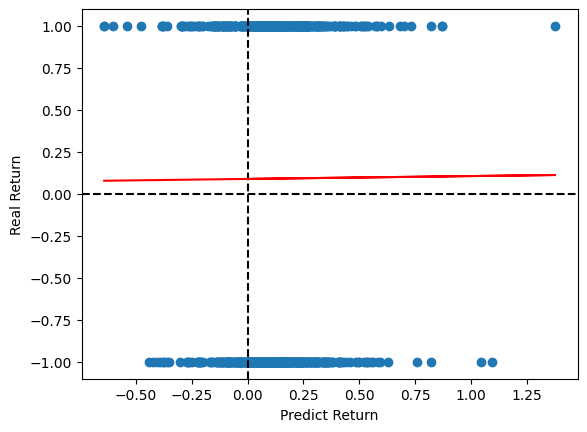

In [132]:
draw_distribution(df_reg_dir)
confusion_matrix(df_reg_dir)

## **LASSO**

In [133]:
## value
time_unit = 60

df_lasso = df_clean[select]
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df_lasso[item] = df_lasso[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df_lasso[item] = df_lasso[item].shift(int(days))
df_lasso['y'] = df_clean['y']
df_lasso = df_lasso.dropna()

for i in range(len(df_lasso)-time_unit):
    # duration = df_lasso[i:i+time_unit]
    today = df_lasso.iloc[i+time_units].name
    next_day = df_lasso.loc[today:].head(2).index[-1]
    duration = df_lasso.loc[:today]
    if today == next_day:
        break
    else:
        y = duration['y']
        x =  duration[select]
        model = Lasso(alpha=0.1).fit(x,y)
        df_lasso.loc[next_day,'predict'] = model.predict(x)[-1]
df_lasso.dropna()

,g8,h10,i11,h7,c8,b3,i10,c10,i2,n4,y,predict
Date,,,,,,,,,,,,
2021-03-15,-0.103986,0.008097,-0.675000,-0.141097,0.357879,14.684359,0.735450,0.332740,-3.090090,-2.542373,0.011688,-0.000039
2021-03-16,0.096712,-0.076305,-4.923077,0.016018,0.060738,-3.443292,0.548780,-0.180240,-1.581897,0.516484,0.000989,0.000150
2021-03-17,-0.104056,0.389130,-1.840336,0.012649,0.184049,-1.416640,-0.281496,0.277687,-3.081481,-0.369565,0.013691,0.000163
2021-03-18,-0.744094,-0.241002,-0.526667,0.015930,0.010363,-1.422531,-0.347945,-0.171447,-0.779359,-0.666667,-0.011603,0.000375
2021-03-19,-1.269231,0.191753,0.415493,0.027798,0.288889,0.340717,0.373950,-0.288462,6.516129,5.586207,-0.000740,0.000190
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,1.903846,-0.073290,-0.536313,0.113529,0.310592,0.671967,-1.090909,-0.302239,-1.142157,-1.000000,-0.012479,0.000416
2024-07-26,0.069536,0.021090,1.216867,0.005543,0.326027,-0.584136,-0.111111,0.336898,-15.965517,-1.000000,-0.000209,0.000401
2024-07-29,0.024768,0.101549,-1.630435,0.010299,-0.094008,-0.477910,17.125000,0.032000,0.046083,-4.250000,-0.005282,0.000400


const      0.001658
predict   -3.463737
dtype: float64
Prevaience: 0.5074626865671642
Accurancy:0.5579793340987371
Precision:0.540084388185654
Recall:0.8687782805429864
F1 Score: 0.666088464874241
Accurancy of No : 0.23776223776223776


,Real Yes,Real No
Predict Yes,0.440873,0.375431
Predict No,0.06659,0.117107


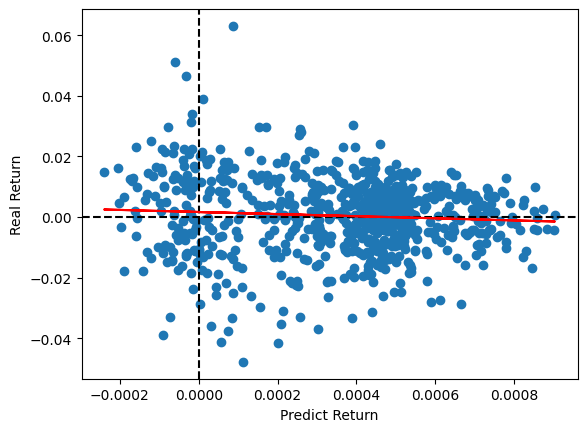

In [134]:
draw_distribution(df_lasso)
confusion_matrix(df_lasso)

In [135]:
## direction
time_unit = 60
df_lasso_dir = df_dir[select]
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df_lasso_dir[item] = df_lasso_dir[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df_lasso_dir[item] = df_lasso_dir[item].shift(int(days))
df_lasso_dir['y'] = df_dir['y']
df_lasso_dir = df_lasso_dir.dropna()

for i in range(len(df_lasso_dir)-time_unit):
    # duration = df_lasso_dir[i:i+time_unit]
    today = df_lasso_dir.iloc[i+time_units].name
    next_day = df_lasso_dir.loc[today:].head(2).index[-1]
    duration = df_lasso_dir.loc[:today]
    if today == next_day:
        break
    else:
        y = duration['y']
        x =  duration[select]
        model = Lasso(alpha=0.1).fit(x,y)
        df_lasso_dir.loc[next_day,'predict'] = model.predict(x)[-1]
df_lasso_dir.dropna()

,g8,h10,i11,h7,c8,b3,i10,c10,i2,n4,y,predict
Date,,,,,,,,,,,,
2021-03-15,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1,0.165412
2021-03-16,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1,0.061680
2021-03-17,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1,0.206412
2021-03-18,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0.228075
2021-03-19,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1,0.106236
2024-07-26,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1,0.104960
2024-07-29,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1,0.103687


const      0.090407
predict    0.007519
dtype: float64
Prevaience: 0.5074626865671642
Accurancy:0.5763490241102182
Precision:0.5451174289245982
Recall:0.997737556561086
F1 Score: 0.7050359712230216
Accurancy of No : 0.14219114219114218


,Real Yes,Real No
Predict Yes,0.506315,0.422503
Predict No,0.001148,0.070034


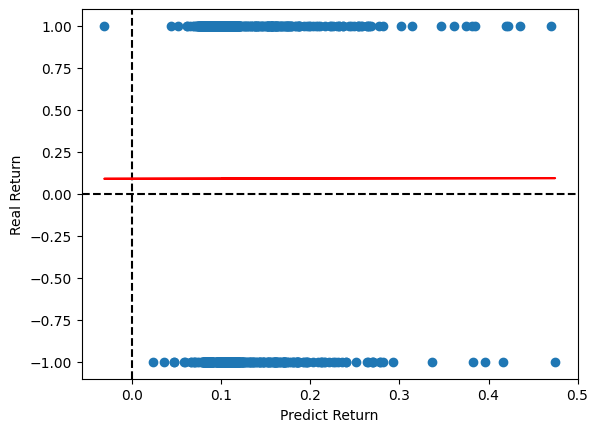

In [136]:
draw_distribution(df_lasso_dir)
confusion_matrix(df_lasso_dir)

### **Random Forest**

In [137]:
## value
ratio = 0.7
df = df_clean.copy()
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df_clean['y']
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']
print(f'n of  train :{len(x_train)}')
print(f'n of  test :{len(x_test)}')

n of  train :609
n of  test :262


predict    0.001846
dtype: float64
Prevaience: 0.5572519083969466
Accurancy:0.5572519083969466
Precision:0.5572519083969466
Recall:1.0
F1 Score: 0.715686274509804
Accurancy of No : 0.0


,Real Yes,Real No
Predict Yes,0.557252,0.442748
Predict No,0.0,0.0


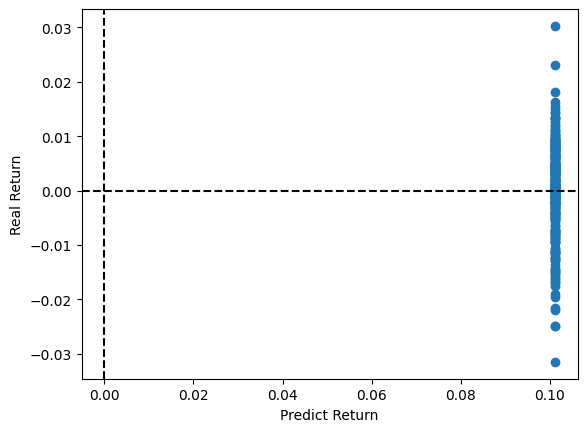

In [139]:
# model = RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150).fit(x_train,y_train)
# x_test.replace(0,1, inplace=True)
# x_train.replace(0,1, inplace=True)
pred_rf = model.predict(x_test)
model1 = RandomForestRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=900).fit(x_train,y_train)
pred1 = model.predict(x_test)
model2 = RandomForestRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=400).fit(x_train,y_train)
pred2 = model.predict(x_test)
model3 = RandomForestRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=800).fit(x_train,y_train)
pred3 = model.predict(x_test)
model4 = RandomForestRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=100).fit(x_train,y_train)
pred4 = model.predict(x_test)
pred_rf = (pred1+pred2+pred3+pred4)/4
# pred_rf = regressor.predict(x_train**7)
df_rf= pd.DataFrame({'y':y_test,'predict':pred_rf})
# df_train = pd.DataFrame({'y':y_train,'predict':pred_rf})
draw_distribution(df_rf)
confusion_matrix(df_rf)

In [140]:
## direction
ratio = 0.7
df = df_dir.copy()
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df_dir['y']
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']
print(f'n of  train :{len(x_train)}')
print(f'n of  test :{len(x_test)}')

n of  train :609
n of  test :262


const      0.103577
predict    0.125960
dtype: float64
Prevaience: 0.5572519083969466
Accurancy:0.5305343511450382
Precision:0.5608465608465608
Recall:0.726027397260274
F1 Score: 0.6328358208955224
Accurancy of No : 0.28448275862068967


,Real Yes,Real No
Predict Yes,0.40458,0.316794
Predict No,0.152672,0.125954


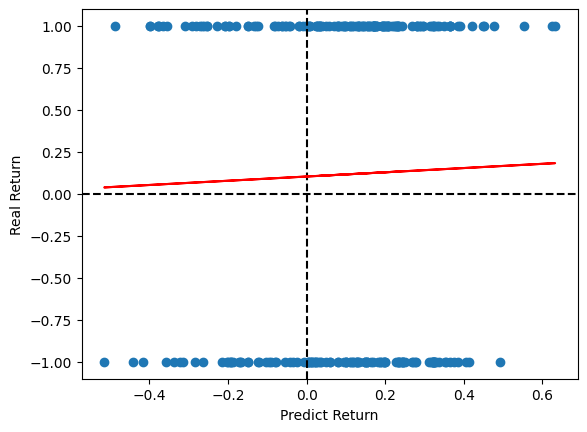

In [141]:
model = RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150).fit(x_train,y_train)
x_test.replace(0,1, inplace=True)
x_train.replace(0,1, inplace=True)
pred_rf = model.predict(x_test)
# pred_rf = regressor.predict(x_train**7)
df_rf= pd.DataFrame({'y':y_test,'predict':pred_rf})
# df_train = pd.DataFrame({'y':y_train,'predict':pred_rf})
draw_distribution(df_rf)
confusion_matrix(df_rf)

In [ ]:
# df_rf_rolling = df_clean[select]
# df_rf_rolling['y'] = df_clean['y']
# time_unit = 90

# # train by interval
# for i in range(len(df_rf_rolling)):
#     duration = df_rf_rolling[i:i+time_unit]
#     today = duration.iloc[-1].name
#     next_day = df_rf_rolling.loc[today:].head(2).index[-1]
#     if today == next_day:
#         break
#     else:
#         y = duration['y']
#         x =  duration[select]
#         model = RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150).fit(x,y)
#         predict = model.predict(df_rf_rolling.loc[today:next_day][select])[-1]
#         df_rf_rolling.loc[next_day,'predict'] = predict
# draw_distribution(df_rf_rolling)
# confusion_matrix(df_rf_rolling)

### **XGBoost**

In [7]:
## value
df = (df_clean - df_clean.mean())/df_clean.std()
# df = (data - data.mean())/data.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']

In [632]:
# best_acc = 0
# best_a = 0
# best_b = 0

# for a in tqdm(range(60,120,10)):
#     for b in range(10,60,10): 
#         df_result = pd.DataFrame()
#         train_unit = a
#         test_unit = b
#         start = 0
#         for i in range((train_unit+test_unit),len(df),test_unit):
#             duration = df.iloc[start:i]
#             x_train = duration.iloc[:-test_unit][select]
#             y_train = duration.iloc[:-test_unit]['y']
#             x_test = duration.iloc[-test_unit:][select]
#             start += test_unit
#             xgboostModel1 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#             predicted1 = xgboostModel1.predict(x_test)
#             xgboostModel2 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#             predicted2 = xgboostModel2.predict(x_test)
#             xgboostModel3 = XGBRegressor(max_depth = 7,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#             predicted3 = xgboostModel3.predict(x_test)
#             xgboostModel4 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#             predicted4 = xgboostModel4.predict(x_test)
#             predicted = (predicted1+predicted2+predicted3+predicted4)/4
#             for d in range(test_unit):
#                 day = duration.iloc[-test_unit:].index[d]
#                 predict = predicted[d]
#                 df_result.loc[day,'y'] = data.loc[day,'y']
#                 df_result.loc[day,'predict'] = predict 
#         acc_matrix = confusion_matrix(df_result)
#         acc = acc_matrix.loc['Predict No','Real No']+acc_matrix.loc['Predict Yes','Real Yes']
#         if best_acc<acc:
#             best_acc = acc
#             best_a = a
#             best_b = b
# print(best_acc,best_a,best_b)
    

In [8]:
df_result = pd.DataFrame()
train_unit = 240
test_unit = 20
start = 0
for i in tqdm(range((train_unit+test_unit),len(df),test_unit)):
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += test_unit
    xgboostModel1 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
    predicted1 = xgboostModel1.predict(x_test)
    xgboostModel2 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
    predicted2 = xgboostModel2.predict(x_test)
    xgboostModel3 = XGBRegressor(max_depth = 7,n_estimators=600, learning_rate=2).fit(x_train,y_train)
    predicted3 = xgboostModel3.predict(x_test)
    xgboostModel4 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
    predicted4 = xgboostModel4.predict(x_test)
    predicted = (predicted1+predicted2+predicted3+predicted4)/4
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 
    

100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


                   y   predict
2021-12-07  0.013228  0.524777
2021-12-08  0.002572  0.422479
2021-12-09 -0.012130  0.910575
2021-12-10  0.002103 -0.825051
2021-12-13 -0.018569  0.907497
...              ...       ...
2024-07-10  0.006926 -0.943260
2024-07-11 -0.021886  0.568657
2024-07-12  0.003804 -0.391722
2024-07-15 -0.000364  0.504732
2024-07-16 -0.001793 -0.307411

[620 rows x 2 columns]
Accurancy:0.5483870967741935


,Real Yes,Real No
Predict Yes,0.303226,0.206452
Predict No,0.245161,0.245161


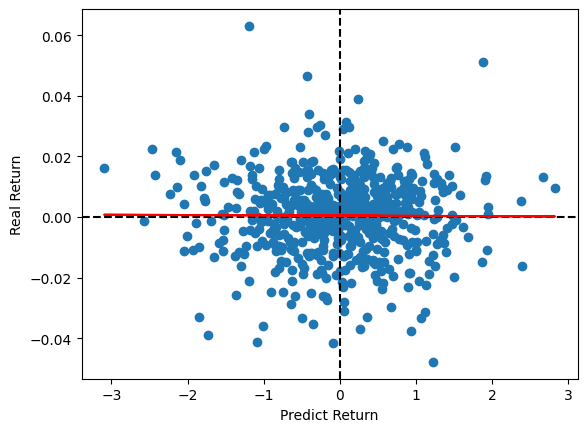

In [9]:
print(df_result)
draw_distribution(df_result)
confusion_matrix(df_result)


In [636]:
abnormal = df_result[abs(df_result['y'])>0.02]
normal = df_result[abs(df_result['y'])<=0.02]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')

26 314
Accuracy of abnormal: 0.3076923076923077
Accuracy of normal: 0.5509554140127388


In [182]:
# best_acc = 0
# best_i = 0
# best_j = 0
# best_k = 0
# best_h = 0
# for i in tqdm(range(0,20)):
#     for j in range(0,15):
#         for k in range(0,10):
#             for h in range(0,5):
#                 xgboostModel1 = XGBRegressor(max_depth = i,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#                 predicted1 = xgboostModel1.predict(x_test)
#                 xgboostModel2 = XGBRegressor(max_depth = j,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#                 predicted2 = xgboostModel2.predict(x_test)
#                 xgboostModel3 = XGBRegressor(max_depth = k,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#                 predicted3 = xgboostModel3.predict(x_test)
#                 xgboostModel4 = XGBRegressor(max_depth = h,n_estimators=600, learning_rate=2).fit(x_train,y_train)
#                 predicted4 = xgboostModel4.predict(x_test)
#                 predicted = (predicted1+predicted2+predicted3+predicted4)/4
#                 df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
#                 # draw_distribution(df_boost)
#                 acc_matrix = confusion_matrix(df_boost)
#                 acc = acc_matrix.loc['Predict Yes','Real Yes']+acc_matrix.loc['Predict No','Real No']
#                 if best_acc< acc:
#                     best_acc = acc
#                     best_i = i
#                     best_j = j
#                     best_k = k
#                     best_h = h
# print(best_acc,best_i,best_j,best_k,best_h)

100%|██████████| 20/20 [2:49:13<00:00, 507.69s/it]  

0.583969465648855 1 1 7


In [637]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# xgboostModel = XGBRegressor(max_depth = 60,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted = xgboostModel.predict(x_test)
xgboostModel1 = XGBRegressor(max_depth = 0,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted1 = xgboostModel1.predict(x_test)
xgboostModel2 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted2 = xgboostModel2.predict(x_test)
xgboostModel3 = XGBRegressor(max_depth = 11,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted3 = xgboostModel3.predict(x_test)
# xgboostModel4 = XGBRegressor(max_depth = 15,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted4 = xgboostModel4.predict(x_test)
# xgboostModel5 = XGBRegressor(max_depth = 25,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted5 = xgboostModel5.predict(x_test)
predicted = (predicted1+predicted2+predicted3)/5
df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
df_boost['y'] = data['y']
draw_distribution(df_boost)
confusion_matrix(df_boost)

ValueError: array length 20 does not match index length 179

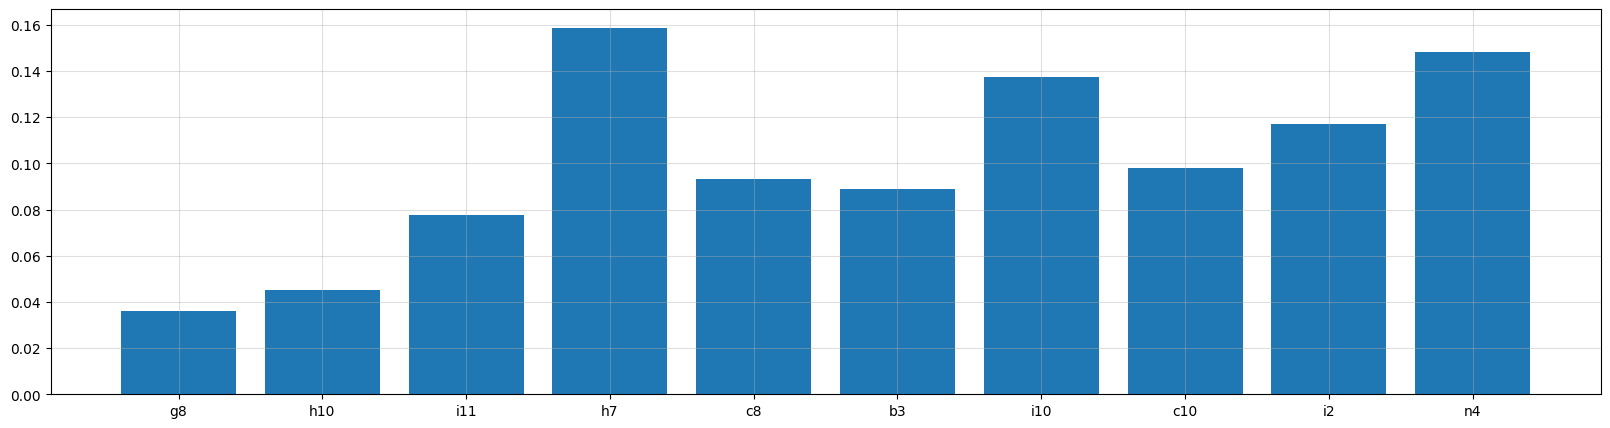

In [ ]:
plt.figure(figsize=(20,5))
plt.grid(True,alpha=0.4)
plt.bar(xgboostModel.feature_names_in_,xgboostModel.feature_importances_)
plt.show()

Accurancy:0.5


,Real Yes,Real No
Predict Yes,0.301527,0.244275
Predict No,0.255725,0.198473


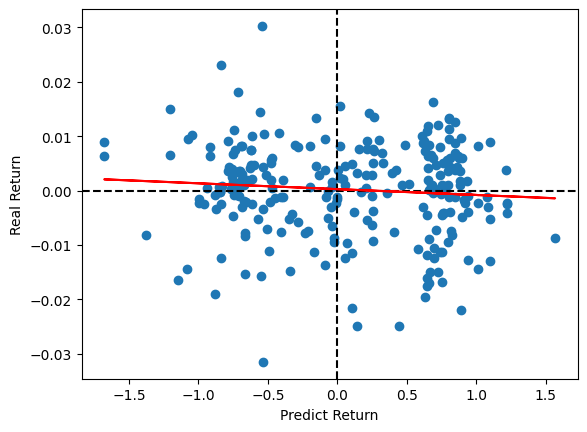

In [496]:
## direction
df = (df_dir - df_dir.mean())/df_dir.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df_dir['y']
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
xgboostModel = XGBRegressor(max_depth = 0,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted = xgboostModel.predict(x_test)
xgboostModel1 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted1 = xgboostModel1.predict(x_test)
xgboostModel2 = XGBRegressor(max_depth = 11,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted2 = xgboostModel2.predict(x_test)
predicted = (predicted+predicted1+predicted2)/3
df_boost_dir = pd.DataFrame({'y':y_test,'predict':predicted})
df_boost_dir['y'] = data['y']
draw_distribution(df_boost_dir)
confusion_matrix(df_boost_dir)


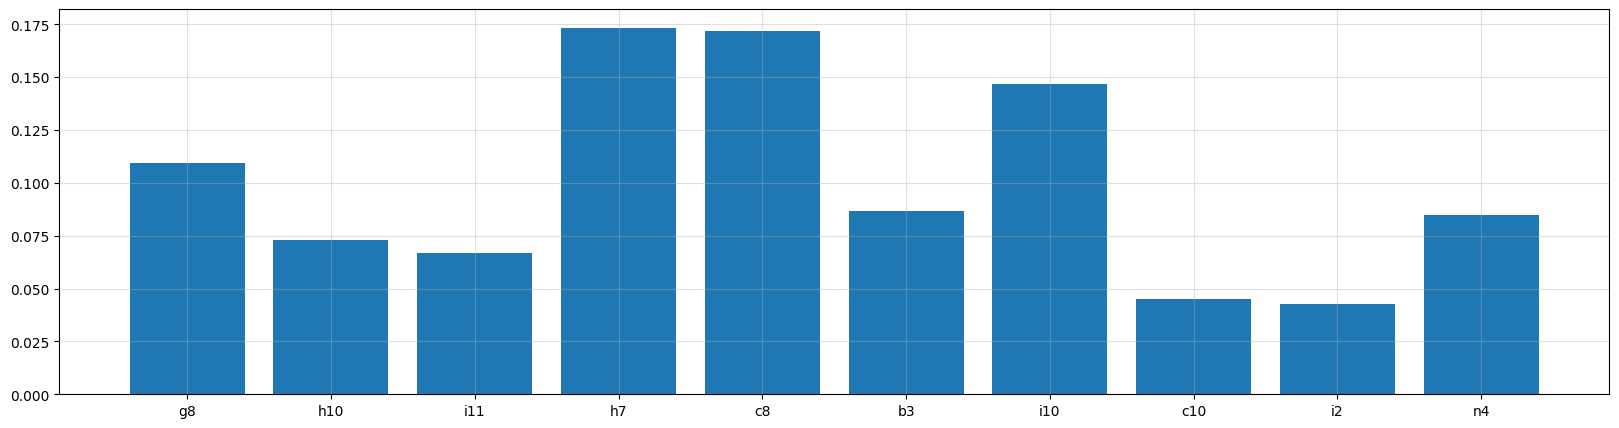

In [497]:
plt.figure(figsize=(20,5))
plt.grid(True,alpha=0.4)
plt.bar(xgboostModel.feature_names_in_,xgboostModel.feature_importances_)
plt.show()

### **HistXGBoost**

In [35]:
## value
df = (df_clean - df_clean.mean())/df_clean.std()
# df = (data - data.mean())/data.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = (df_clean['y'] - df_clean['y'].mean())/df_clean['y'].std()
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
# select.remove('y')
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']


Accurancy:0.5801526717557252


,Real Yes,Real No
Predict Yes,0.343511,0.206107
Predict No,0.21374,0.236641


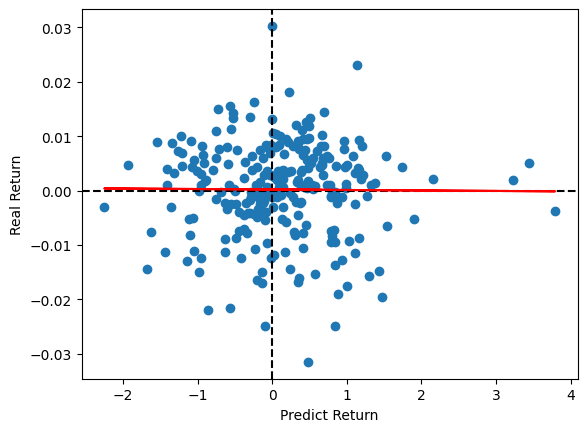

In [506]:
model = HistGradientBoostingRegressor(max_depth = 3, learning_rate=2).fit(x_train,y_train)
predicted = model.predict(x_test)
model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
predicted1 = model1.predict(x_test)
model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
predicted2 = model2.predict(x_test)
model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
predicted3 = model3.predict(x_test)
# model4 = HistGradientBoostingRegressor(max_depth = 6, learning_rate=2).fit(x_train,y_train)
# predicted4 = model4.predict(x_test)
# xgboostModel = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=5).fit(x_train,y_train)
# predicted3 = xgboostModel1.predict(x_test)
# xgboostMode2 = XGBRegressor(max_depth = 6,n_estimators=600, learning_rate=5).fit(x_train,y_train)
# predicted4 = xgboostModel2.predict(x_test)
predicted = (predicted1+predicted2+predicted3)/3
df_histboost = pd.DataFrame({'y':y_test,'predict':predicted})
df_histboost['y'] = data['y']
draw_distribution(df_histboost)
confusion_matrix(df_histboost)

Prevaience: 0.5114503816793893
Accurancy:0.5610687022900763
Precision:0.5714285714285714
Recall:0.5671641791044776
F1 Score: 0.5692883895131086
Accurancy of No : 0.5546875


,Real Yes,Real No
Predict Yes,0.290076,0.217557
Predict No,0.221374,0.270992


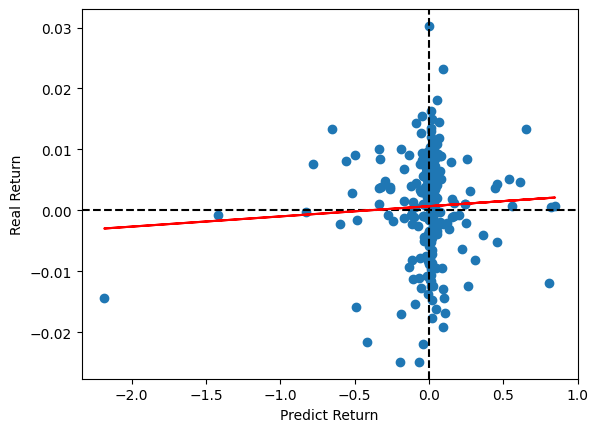

In [28]:
from sklearn.linear_model import QuantileRegressor,PassiveAggressiveRegressor,BayesianRidge,ARDRegression,TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.neural_network import MLPRegressor
model7 = RadiusNeighborsRegressor(radius=1).fit(x_train,y_train)
predicted7 = model7.predict(x_test)
df_histboost = pd.DataFrame({'y':y_test,'predict':predicted7})
df_histboost['y'] = data['y']
draw_distribution(df_histboost)
confusion_matrix(df_histboost)

### Best for now

100%|██████████| 24/24 [00:04<00:00,  5.04it/s]


                   y   predict
2021-12-28 -0.005177 -0.040804
2021-12-29  0.000334  0.017250
2021-12-30 -0.004437  0.118353
2021-12-31 -0.005235 -0.243511
2022-01-03  0.006789  0.272812
...              ...       ...
2024-06-25  0.007186  0.170607
2024-06-26  0.003599  0.340474
2024-06-27  0.002025  0.067013
2024-06-28 -0.007432 -0.159435
2024-07-01  0.003516  0.218609

[600 rows x 2 columns]
Prevaience: 0.5433333333333333
Accurancy:0.5933333333333334
Precision:0.629746835443038
Recall:0.6104294478527608
F1 Score: 0.6199376947040498
Accurancy of No : 0.572992700729927


,Real Yes,Real No
Predict Yes,0.331667,0.195
Predict No,0.211667,0.261667


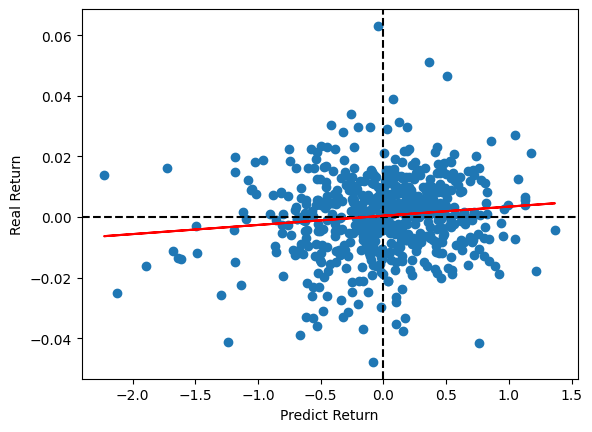

In [36]:
from sklearn.linear_model import QuantileRegressor,PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.neural_network import MLPRegressor
df_result = pd.DataFrame()
train_unit = 252
test_unit = 25
start = 0
for i in tqdm(range((train_unit+test_unit),len(df),test_unit)):
    # print(start,i)
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += test_unit
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.4).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted1+predicted2+predicted3+predicted4+predicted5+predicted6+predicted7)/7
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
print(df_result)
draw_distribution(df_result)
confusion_matrix(df_result)
# abnormal = df_result[abs(df_result['y'])>0.02]
# normal = df_result[abs(df_result['y'])<=0.02]
# print(len(abnormal),len(normal))
# accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
# accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
# print(f'Accuracy of abnormal: {accuracy_ab}')
# print(f'Accuracy of normal: {accuracy}')

100%|██████████| 749/749 [01:53<00:00,  6.59it/s]

                   y   predict
2021-06-11  0.001575  0.135068
2021-06-14  0.007298  0.114277
2021-06-15 -0.005899  0.118315
2021-06-16 -0.005554  0.693347
2021-06-17  0.018347  0.248257
...              ...       ...
2024-07-24 -0.021571 -0.008680
2024-07-25 -0.012479 -0.201696
2024-07-26 -0.000209 -0.132921
2024-07-29 -0.005282 -0.050436
2024-07-30 -0.016868 -0.000690

[749 rows x 2 columns]
Prevaience: 0.5420560747663551
Accurancy:0.5794392523364486
Precision:0.6117936117936118
Recall:0.6133004926108374
F1 Score: 0.6125461254612546
Accurancy of No : 0.5393586005830904
             Real Yes   Real No
Predict Yes  0.332443  0.210948
Predict No   0.209613  0.246996
71 678
Accuracy of abnormal: 0.6338028169014085
Accuracy of normal: 0.5737463126843658


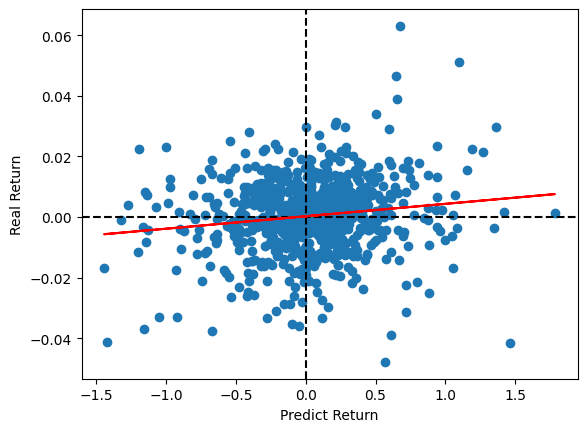

In [527]:
from sklearn.linear_model import QuantileRegressor,PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.neural_network import MLPRegressor
df_result = pd.DataFrame()
train_unit = 122
test_unit = 1
start = 0
for i in tqdm(range((train_unit),len(df))):
    # print(start,i)
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += 1
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1.4).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted1+predicted2+predicted3+predicted4+predicted5+predicted6+predicted7)/7
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
print(df_result)
draw_distribution(df_result)
acc_matrix = confusion_matrix(df_result)
print(acc_matrix)
abnormal = df_result[abs(df_result['y'])>0.02]
normal = df_result[abs(df_result['y'])<=0.02]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')



100%|██████████| 749/749 [03:30<00:00,  3.55it/s]

                   y   predict
2021-06-11  0.001575  0.040182
2021-06-14  0.007298  0.608168
2021-06-15 -0.005899 -0.502035
2021-06-16 -0.005554 -0.939639
2021-06-17  0.018347  0.520564
...              ...       ...
2024-07-24 -0.021571  0.776650
2024-07-25 -0.012479  0.155280
2024-07-26 -0.000209 -0.472140
2024-07-29 -0.005282 -0.404880
2024-07-30 -0.016868  0.121815

[749 rows x 2 columns]
Prevaience: 0.5420560747663551
Accurancy:0.5607476635514018
Precision:0.59846547314578
Recall:0.5763546798029556
F1 Score: 0.5872020075282308
Accurancy of No : 0.5422740524781341
             Real Yes   Real No
Predict Yes  0.312417  0.209613
Predict No    0.22964  0.248331
71 678
Accuracy of abnormal: 0.5915492957746479
Accuracy of normal: 0.5575221238938053


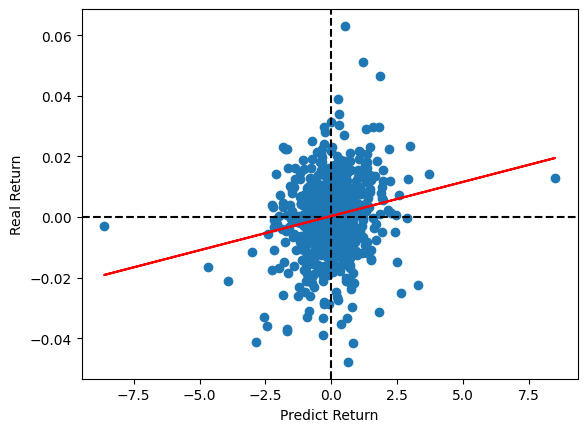

In [22]:
from sklearn.linear_model import QuantileRegressor,PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.neural_network import MLPRegressor
from sklearn.utils.fixes import sp_version, parse_version
df_result = pd.DataFrame()
train_unit = 122
test_unit = 1
start = 0
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
for i in tqdm(range((train_unit),len(df))):
    # print(start,i)
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += 1
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    # model1 =  QuantileRegressor(quantile=0.1, solver=solver).fit(x_train,y_train)
    # predicted1 = model1.predict(x_test)
    # model2 =  QuantileRegressor(quantile=0.6, solver=solver).fit(x_train,y_train)
    # predicted2 = model2.predict(x_test)
    model3 = MLPRegressor(random_state=5, max_iter=500).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted3+predicted4+predicted5+predicted6+predicted7)/3
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
print(df_result)
draw_distribution(df_result)
acc_matrix = confusion_matrix(df_result)
print(acc_matrix)
abnormal = df_result[abs(df_result['y'])>0.02]
normal = df_result[abs(df_result['y'])<=0.02]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')


In [450]:
print(len(df_result),len(df_result[df_result['predict'].isna()==True]))
df_result[(df_result['accuracy']=='FP')|(df_result['accuracy']=='FN')]

749 0


,y,predict,predict_signal,real_signal,accuracy
2021-06-15,-0.005899,0.168725,1.0,-1.0,FP
2021-06-16,-0.005554,0.667668,1.0,-1.0,FP
2021-06-18,-0.004856,0.055467,1.0,-1.0,FP
2021-06-21,0.004692,-0.530006,-1.0,1.0,FN
2021-06-22,0.009786,-0.442613,-1.0,1.0,FN
...,...,...,...,...,...
2024-07-16,-0.001793,0.275524,1.0,-1.0,FP
2024-07-17,-0.013757,0.205595,1.0,-1.0,FP
2024-07-18,-0.012398,0.234074,1.0,-1.0,FP
2024-07-19,-0.011359,0.020449,1.0,-1.0,FP


In [37]:
## direction 
df = (df_dir - df_dir.mean())/df_dir.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = (df_dir['y'] - df_dir['y'].mean())/df_dir['y'].std()
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
# select.remove('y')
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']

# model = HistGradientBoostingRegressor(max_depth = 8, learning_rate=2).fit(x_train,y_train)
# predicted = model.predict(x_test)
# df_histboost_dir = pd.DataFrame({'y':y_test,'predict':predicted})
# df_histboost_dir['y'] = data['y']
# draw_distribution(df_histboost_dir)
# confusion_matrix(df_histboost_dir)

100%|██████████| 749/749 [03:34<00:00,  3.49it/s]

                   y   predict
2021-06-11  0.001575 -0.446068
2021-06-14  0.007298  0.249558
2021-06-15 -0.005899  0.015674
2021-06-16 -0.005554  0.512833
2021-06-17  0.018347  0.212780
...              ...       ...
2024-07-24 -0.021571  0.001304
2024-07-25 -0.012479 -0.081542
2024-07-26 -0.000209 -0.266949
2024-07-29 -0.005282 -0.621422
2024-07-30 -0.016868 -0.108028

[749 rows x 2 columns]
Prevaience: 0.5420560747663551
Accurancy:0.5086782376502003
Precision:0.5502645502645502
Recall:0.5123152709359606
F1 Score: 0.5306122448979592
Accurancy of No : 0.5043731778425656
             Real Yes   Real No
Predict Yes  0.277704  0.226969
Predict No   0.264352  0.230975
71 678
Accuracy of abnormal: 0.4225352112676056
Accuracy of normal: 0.5176991150442478


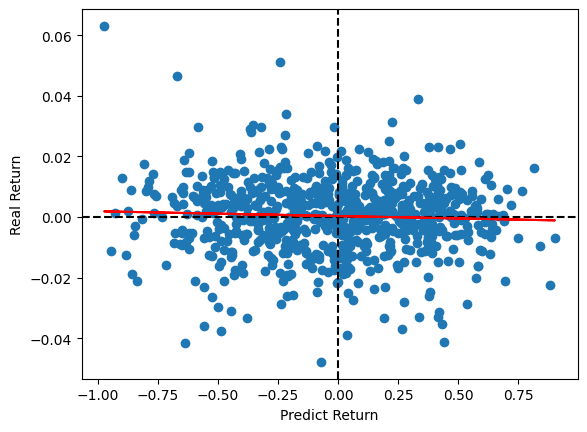

In [38]:
from sklearn.linear_model import QuantileRegressor,PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.neural_network import MLPRegressor
df_result = pd.DataFrame()
train_unit = 122
test_unit = 1
start = 0
for i in tqdm(range((train_unit),len(df))):
    # print(start,i)
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += 1
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1.4).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted1+predicted2+predicted3+predicted4+predicted5+predicted6+predicted7)/7
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
print(df_result)
draw_distribution(df_result)
acc_matrix = confusion_matrix(df_result)
print(acc_matrix)
abnormal = df_result[abs(df_result['y'])>0.02]
normal = df_result[abs(df_result['y'])<=0.02]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')



### **LSTM**

n of x train :(765, 10)
n of y train :(765,)
n of x train :(328, 10)
n of y train :(328,)
### After Normalization ###
(1093, 10)
(1093, 1)

#### Input Data shape ####
(1033, 60, 10)

#### Output Data shape ####
(1033, 1)

#### Training Data shape ####
(733, 60, 10)
(733, 1)

#### Testing Data shape ####
(300, 60, 10)
(300, 1)
Number of TimeSteps: 60
Number of Features: 10
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1711
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0097
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0120
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0103
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0097
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0111
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0094
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0102
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0116
Epoc

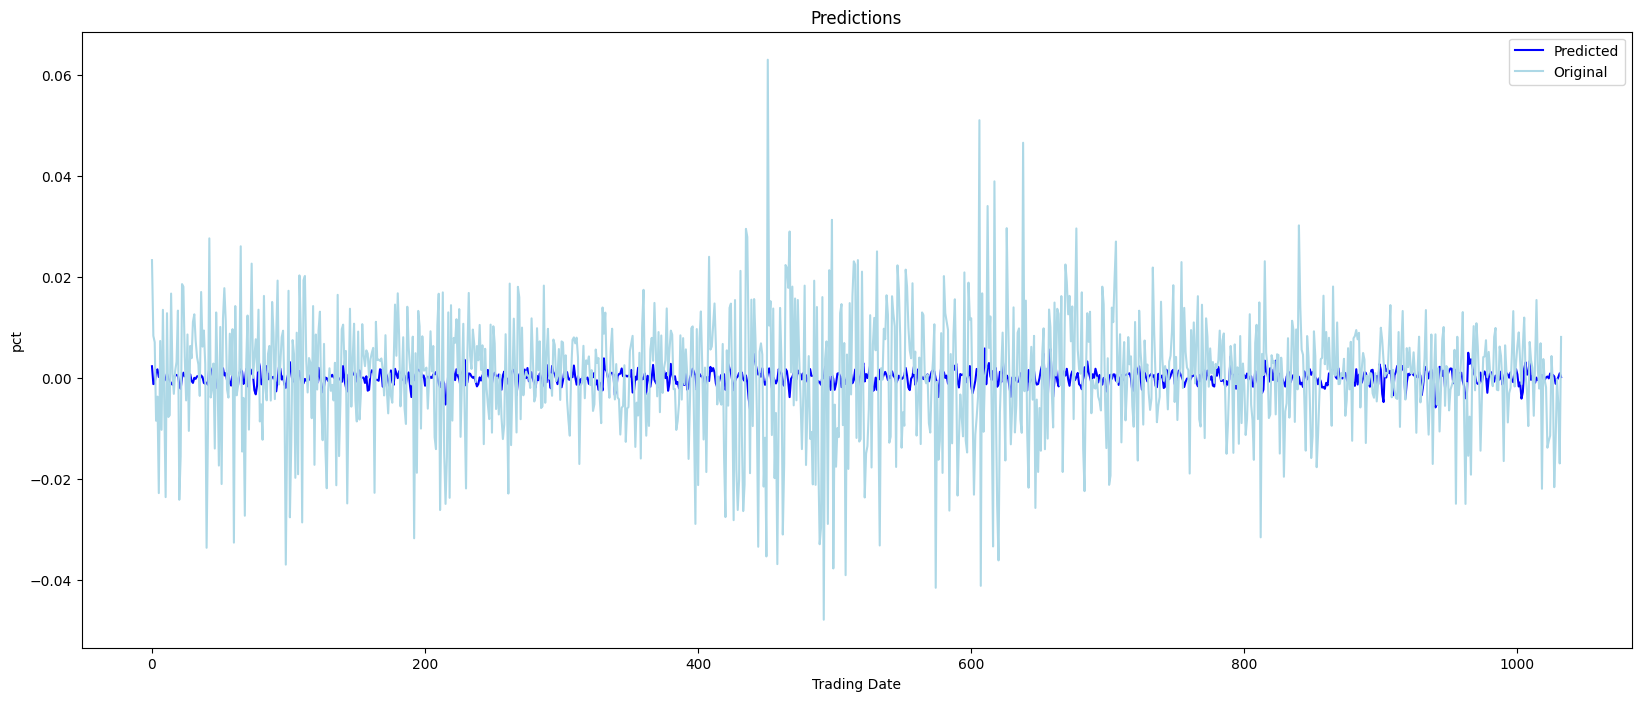

const      0.000558
predict    0.165914
dtype: float64
Prevaience: 0.57
Accurancy:0.5366666666666666
Precision:0.5930232558139535
Recall:0.5964912280701754
F1 Score: 0.5947521865889214
Accurancy of No : 0.4573643410852713


,Real Yes,Real No
Predict Yes,0.34,0.233333
Predict No,0.23,0.196667


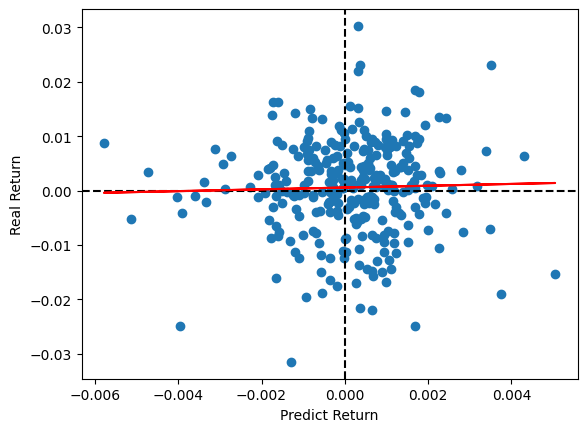

In [ ]:
## value
ratio = 0.7
df = df_clean.copy()
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df['y']
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = np.array(df_train[select])
x_test = np.array(df_test[select])

y_train = np.array(df_train['y'])
y_test = np.array(df_test['y'])
print(f'n of x train :{x_train.shape}')
print(f'n of y train :{y_train.shape}')
print(f'n of x train :{x_test.shape}')
print(f'n of y train :{y_test.shape}')

FullData = df[select]
# FullData.replace([np.inf, -np.inf], np.nan, inplace=True) 
# FullData.dropna(inplace=True) 
FullDataY = df['y'].values
FullData = FullData.values

# sc = StandardScaler()
sc=MinMaxScaler()
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
DataScalerY = sc.fit(FullDataY.reshape(-1, 1))
Y=DataScalerY.transform(FullDataY.reshape(-1, 1))
# X.replace([np.inf, -np.inf], np.nan, inplace=True) 
# X.dropna(inplace=True) 
 
print('### After Normalization ###')
print(X.shape)
print(Y.shape)

X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=60  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = Y[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], X.shape[1])
print('\n#### Input Data shape ####')
print(X_data.shape)
 
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)

TestingRecords=300
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)
 
# Initialising the RNN
regressor = Sequential()
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
print(len(TrainPredictions),len(TestPredictions))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullDataY[TimeSteps:]

plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
plt.title('Predictions')
plt.xlabel('Trading Date')
plt.ylabel('pct')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

df_lstm = pd.DataFrame({'y':[i for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
draw_distribution(df_lstm)
confusion_matrix(df_lstm)

n of x train :(765, 10)
n of y train :(765,)
n of x train :(328, 10)
n of y train :(328,)
### After Normalization ###
(1093, 10)
(1093, 1)

#### Input Data shape ####
(1033, 60, 10)

#### Output Data shape ####
(1033, 1)

#### Training Data shape ####
(733, 60, 10)
(733, 1)

#### Testing Data shape ####
(300, 60, 10)
(300, 1)
Number of TimeSteps: 60
Number of Features: 10
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4936
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2496
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2485
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2457
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2445
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2452
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2465
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2488
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2495
Epoc

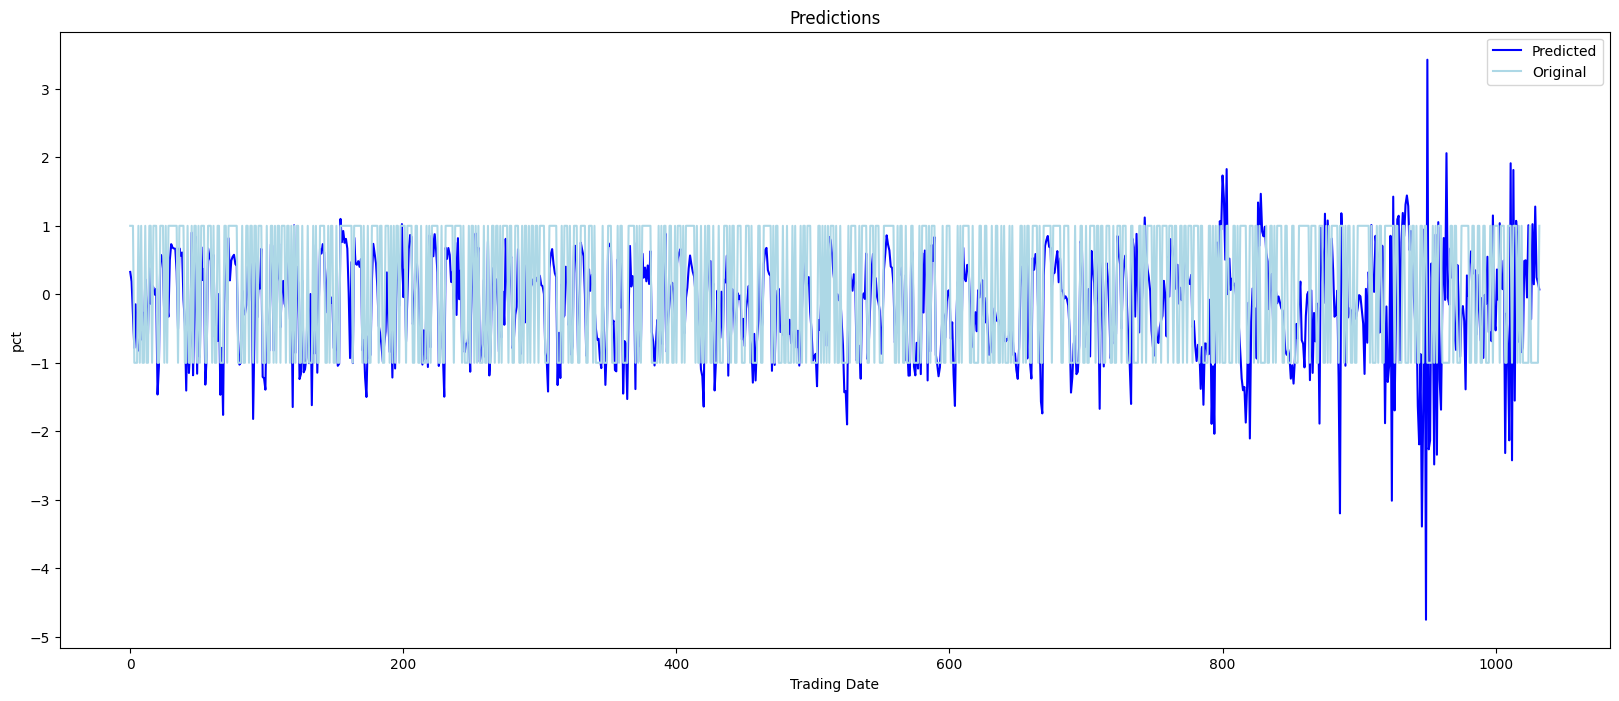

const      0.126111
predict   -0.094895
dtype: float64
Prevaience: 0.57
Accurancy:0.4666666666666667
Precision:0.5413533834586466
Recall:0.42105263157894735
F1 Score: 0.47368421052631576
Accurancy of No : 0.5271317829457365


,Real Yes,Real No
Predict Yes,0.24,0.203333
Predict No,0.33,0.226667


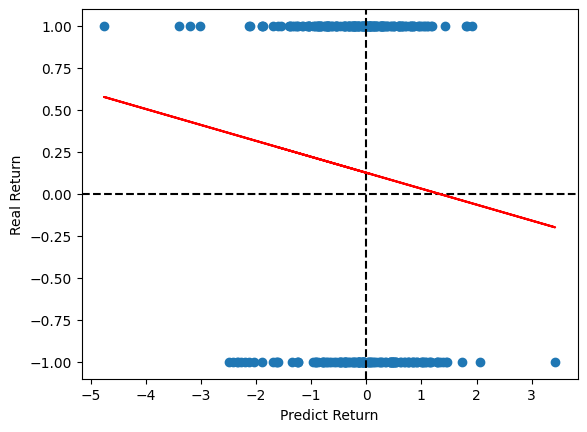

In [ ]:
## direction
ratio = 0.7
df = df_dir.copy()
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df['y'] = df_dir['y']
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = np.array(df_train[select])
x_test = np.array(df_test[select])

y_train = np.array(df_train['y'])
y_test = np.array(df_test['y'])
print(f'n of x train :{x_train.shape}')
print(f'n of y train :{y_train.shape}')
print(f'n of x train :{x_test.shape}')
print(f'n of y train :{y_test.shape}')

FullData = df[select]
# FullData.replace([np.inf, -np.inf], np.nan, inplace=True) 
# FullData.dropna(inplace=True) 
FullDataY = df['y'].values
FullData = FullData.values

# sc = StandardScaler()
sc=MinMaxScaler()
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
DataScalerY = sc.fit(FullDataY.reshape(-1, 1))
Y=DataScalerY.transform(FullDataY.reshape(-1, 1))
# X.replace([np.inf, -np.inf], np.nan, inplace=True) 
# X.dropna(inplace=True) 
 
print('### After Normalization ###')
print(X.shape)
print(Y.shape)

X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=60  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = Y[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], X.shape[1])
print('\n#### Input Data shape ####')
print(X_data.shape)
 
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)

TestingRecords=300
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)
 
# Initialising the RNN
regressor = Sequential()
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
print(len(TrainPredictions),len(TestPredictions))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullDataY[TimeSteps:]

plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
plt.title('Predictions')
plt.xlabel('Trading Date')
plt.ylabel('pct')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

df_lstm_dir = pd.DataFrame({'y':[i for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
draw_distribution(df_lstm_dir)
confusion_matrix(df_lstm_dir)

In [ ]:
# plt.figure(figsize=(20,8))
# ig, ax1 = plt.subplots() 
  
# ax1.set_xlabel('times') 
# ax1.set_ylabel('y_pct', color = 'orange') 
# ax1.plot(data.index,data['y'], color = 'orange') 
# ax1.tick_params(axis ='y', labelcolor = 'orange') 

# ax2 = ax1.twinx() 
  
# ax2.set_ylabel('factor_pct', color = 'blue') 
# ax2.plot(data.index,data['n7'].pct_change().shift(1), color = 'blue') 
# ax2.tick_params(axis ='y', labelcolor = 'blue') 

In [ ]:
# from sklearn.linear_model import Ridge,RidgeCV,LogisticRegression,PoissonRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
# model = Ridge(20).fit(x_train,y_train)
# df_ridge = pd.DataFrame({'y':y_test, 'predict': model.predict(x_test)})
# df_ridge

In [ ]:
# df_reg4 = data.copy()
# df_reg4 = df_reg4[k_means_pick].pct_change()
# df_reg4.replace([np.inf,-np.inf],0,inplace=True)
# df_reg4['y'] = data['y']
# df_reg4 = df_reg4.dropna()
# time_unit = 90

# for i in range(len(df_reg4)-time_units+1):
#     today = df_reg4.iloc[i+time_units-1].name
#     next_day = df_reg4.loc[today:].head(2).index[-1]
#     duration = df_reg4.iloc[i:i+time_units]
#     duration.replace([np.nan,np.inf,-np.inf],1,inplace=True)
#     # duration = (duration - duration.mean())/duration.std()

#     Y = duration['y']
#     X = duration[k_means_pick]
#     model =RidgeCV(1).fit(X,Y)
#     predict = model.predict(df_reg4.loc[today:next_day][k_means_pick])
#     df_reg4.loc[next_day,'predict'] = predict[-1] 
# draw_distribution(df_reg4)
# confusion_matrix(df_reg4)

In [ ]:
# df_reg5 = data.copy()
# df_reg5 = df_reg5[k_means_dir].pct_change()
# df_reg5['y'] = data['y']
# df_reg5 = df_reg5.dropna()
# time_unit = 125

# for i in range(len(df_reg5)-time_units+1):
#     today = df_reg5.iloc[i+time_units-1].name
#     next_day = df_reg5.loc[today:].head(2).index[-1]
#     duration = df_reg5.iloc[i:i+time_units]
#     duration = (duration - duration.mean())/duration.std()

#     Y = duration['y']
#     X = duration[k_means_dir]
#     model =HistGradientBoostingRegressor(learning_rate=100).fit(X,Y)
#     predict = model.predict(df_reg5.loc[today:next_day][k_means_dir])
#     df_reg5.loc[next_day,'predict'] = predict[-1] 
# draw_distribution(df_reg5)
# confusion_matrix(df_reg5)

### **DL: LSTM**

In [ ]:
# Visualizing the input and output being sent to the LSTM model
# for inp, out in zip(X_train[0:2], y_train[0:2]):
#     print(inp,'--', out)

## 綜合

In [ ]:
# df_mix = pd.concat([df_boost[['y','predict']],df_reg[['predict']],df_rf[['predict']]],axis=1).dropna()
# df_mix.columns = ['y','boost','reg','rf']
# df_mix['boost_dir'] = np.where(df_mix['boost']<0,-1,1)
# df_mix['reg_dir'] = np.where(df_mix['reg']<0,-1,1)
# df_mix['rf_dir'] = np.where(df_mix['rf']<0,-1,1)
# df_mix['sum'] = df_mix[['boost_dir','reg_dir','rf_dir']].sum(axis=1)
# df_mix['predict'] = np.where(df_mix['sum']>0,1,-1)
# draw_distribution(df_mix)
# confusion_matrix(df_mix)

In [ ]:
# df_mix = pd.concat([df_boost[['y','predict']],df_rf['predict'],df_reg2['predict']],axis=1).dropna()
# df_mix.columns = ['y','boost','rf','lasso']
# df_mix
# df_mix['boost_dir'] = np.where(df_mix['boost']<0,-1,1)
# df_mix['rf_dir'] = np.where(df_mix['rf']<0,-1,1)
# df_mix['lasso_dir'] = np.where(df_mix['lasso']<0,-1,1)
# df_mix['predict'] = np.where((df_mix['boost']<0)&(df_mix['rf']<0)&(df_mix['lasso']<0),-1,np.where((df_mix['boost']>0)&(df_mix['rf']>0),1,-1))
# # df_mix['sum'] = df_mix[['boost_dir','reg_dir']].sum(axis=1)
# # df_mix['predict'] = np.where(df_mix['sum']>0,1,np.where(df_mix['sum']==0,df_mix['reg_dir'],-1))
# draw_distribution(df_mix)
# confusion_matrix(df_mix)

# CNN

In [ ]:
# from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv1D,MaxPooling1D
# model = Sequential()
# model.add(Conv1D(filters=8,
#                  kernel_size=5,
#                  padding='same',
#                  input_shape = (X_train.shape[1],X_train.shape[2]),
#                  activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
# model.add(Conv1D(filters=16,
#                  kernel_size=5,
#                  padding='same',
#                  activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
# model.add(Dropout(0.25))
# # model = Sequential()
# model.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# model.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# model.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
# model.add(Dense(units = 1))
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# model.fit(X_train, y_train, batch_size = 10, epochs = 50)
# model.compile(loss = 'mae',optimizer='adam',metrics=['accuracy'])
# model.fit(X_train,y_train,epochs=50,batch_size=10)

In [ ]:
# TrainPredictions=DataScaler.inverse_transform(model.predict(X_train))
# TestPredictions=DataScaler.inverse_transform(model.predict(X_test))
# print(len(TrainPredictions),len(TestPredictions))
 
# FullDataPredictions=np.append(TrainPredictions, TestPredictions)
# FullDataOrig=FullDataY[TimeSteps:]

# plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
# plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
# plt.title('Predictions')
# plt.xlabel('Trading Date')
# plt.ylabel('pct')
# plt.legend()
# fig=plt.gcf()
# fig.set_figwidth(20)
# fig.set_figheight(8)
# plt.show()

In [ ]:
# df_lstm2 = pd.DataFrame({'y':[i[0] for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
# draw_distribution(df_lstm2)
# confusion_matrix(df_lstm2)

In [ ]:
# df_index4 = pd.DataFrame()

# for i in data.columns:
#     max_corr = 0
#     best_shift = 0
#     for j in range(0,252):
#         df =pd.DataFrame()
#         df['y'] = data['y']
#         df[i] = data[i].pct_change().shift(-j)
#         if abs(df.corr().loc['y',i])>abs(max_corr):
#             max_corr = df.corr().loc['y',i]
#             best_shift = -j
#     df_index4.loc[:,i] = [max_corr,best_shift]
# df_index4  = df_index4.T
# lagging_factors = df_index4.sort_values(0,ascending=False).head(5).index.to_list()
# lagging_factors.remove('y')
# print(lagging_factors)